# ISMIR 2021 Tempo, Beat, and Downbeat Estimation Tutorial

This is the accompanying notebook for the Tempo, Beat, and Downbeat Estimation tutorial.

The book can be found here: https://tempobeatdownbeat.github.io/tutorial/intro.html



## Prerequisites

To run this notebook you need the following packages

- tensorflow (version 1.x)
- keras
- madmom
- mirdata

All additionally needed packages should come as dependencies.

In [1]:
%tensorflow_version 1.x
%matplotlib inline

TensorFlow 1.x selected.


In [2]:
!pip install h5py==2.10.0
!pip install keras==2.3.1
!pip install mido
!pip install madmom
!pip install mirdata

     |████████████████████████████████| 2.9 MB 5.0 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 20.0 MB 1.3 MB/s 
     |████████████████████████████████| 51 kB 9.2 MB/s 
  Created wheel for madmom: filename=madmom-0.16.1-cp37-cp37m-linux_x86_64.whl size=20934195 sha256=d49b859d4da1c8b3b13d18e3643f6ca11cc39eb38ddec49dad6eaba7d57d65c5
  Stored in directory: /root/.cache/pip/wheels/af/90/61/393ceef814b55b12d1b59b5ed3a2b2a3457a55d39b7363b975
Successfully built madmom
  Attempting uninstall: mido
    Found existing installation: mido 1.2.6
    Uninstalling mido-1.2.6:
      Successfully uninstalled mido-1.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
magenta 0.3.19 requires mido==1.2.6, but you have mido 1.2.10 which 

## Google Drive

If you have a Google account and want to save the trained models or predictions, the easiest way is to mount your drive. Everything is then stored in your own drive.

In [3]:
PATH = '/'

In [4]:
# run the following commands if you want to save everything in your Google drive
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
# set PATH to point to your Google Drive
PATH = '/content/drive/My Drive'

Mounted at /content/drive


## Setting up environment

We need to import a couple of packages.

In [5]:
import os
import sys
import warnings

import numpy as np
import tensorflow as tf
import keras
import madmom
import mirdata
import librosa
import librosa.display

from scipy.ndimage import maximum_filter1d
from scipy.interpolate import interp1d
from scipy.signal import argrelmax

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [6]:
# ignore certain warnings
warnings.filterwarnings('ignore')

# set default figure size
plt.rcParams['figure.figsize'] = (20, 6)

## Setting up GPU

GPU computation greatly reduces the training and inference times.

In [7]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon Nov  8 08:29:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

On a local machine, these settings might be needed if the GPU is not found automatically

In [8]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


Limit GPU memory so other processes can use the remainder

In [9]:
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.Session(config=config))

# Dataset handling

We use the well-known GTZAN dataset aus our dataset. This dataset comprises 1000 songs of 10 different genres.
We use a subset of 10 randomly chosen songs per genre as our "mini" dataset.
This greatly reduces the required training time, but also leads to decreased  (and less predictable) performance.

In [10]:
gtzan = mirdata.initialize('gtzan_genre', version='mini')
gtzan.download()
len(gtzan.track_ids)

INFO: Downloading ['mini', 'tempo_beat_annotations'] to /root/mir_datasets/gtzan_genre
INFO: [mini] downloading main.zip
118MB [00:05, 23.1MB/s]
INFO: [tempo_beat_annotations] downloading annot.zip
632kB [00:00, 1.81MB/s] 


100

You can always use the full dataset to re-run the experiments by uncommenting the following cell.

In [11]:
# # obtain copy of GTZAN data (use a mirror URL for faster access)
# !pip install gdown
# !mkdir -p /root/mir_datasets/gtzan_genre/gtzan_genre/
# !gdown --id 1cwb2vAKryAYqkP2D86bpO6mbVlQmVhjN --output /root/mir_datasets/gtzan_genre/gtzan_genre/genres.tar.gz
# # use the following line to initialise the dataset (i.e. the full version without 'mini')
# gtzan = mirdata.initialize('gtzan_genre')
# gtzan.download()
# len(gtzan.track_ids)

## Define dataset splits

We split all tracks into two subsets, one used for training, the other for testing.
We use a 80/20 split, i.e. 80 songs for training and the remaining 20 for testing the model's performance on unseen data.

In [12]:
from sklearn.model_selection import train_test_split

tracks = gtzan.load_tracks()

train_files, test_files = train_test_split(list(tracks.keys()), test_size=0.2, random_state=1234)
len(train_files), len(test_files), test_files[-1]

(80, 20, 'pop.00002')

# Audio pre-processing

Our approach operates on a spectrogram representation of the audio signal.

We define a processor which transforms the raw audio into a spectrogram with 100 frames per second and 81 frequency bins.

In [13]:
from madmom.processors import ParallelProcessor, SequentialProcessor
from madmom.audio.signal import SignalProcessor, FramedSignalProcessor
from madmom.audio.stft import ShortTimeFourierTransformProcessor
from madmom.audio.spectrogram import FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor

FPS = 100
FFT_SIZE = 2048
NUM_BANDS = 12

# define pre-processor
class PreProcessor(SequentialProcessor):
    def __init__(self, frame_size=FFT_SIZE, num_bands=NUM_BANDS, log=np.log, add=1e-6, fps=FPS):
        # resample to a fixed sample rate in order to get always the same number of filter bins
        sig = SignalProcessor(num_channels=1, sample_rate=44100)
        # split audio signal in overlapping frames
        frames = FramedSignalProcessor(frame_size=frame_size, fps=fps)
        # compute STFT
        stft = ShortTimeFourierTransformProcessor()
        # filter the magnitudes
        filt = FilteredSpectrogramProcessor(num_bands=num_bands)
        # scale them logarithmically
        spec = LogarithmicSpectrogramProcessor(log=log, add=add)
        # instantiate a SequentialProcessor
        super(PreProcessor, self).__init__((sig, frames, stft, filt, spec, np.array))
        # safe fps as attribute (needed for quantization of events)
        self.fps = fps

# NN infrastructure

We create a multi-task model to jointly predict tempo, beats and doenbeats, which mostly follows our ISMIR 2020 paper "Deconstruct, analyse, reconstruct: how to improve tempo, beat, and downbeat estimation.".

In [14]:
import keras.backend as K

from keras.models import Sequential, Model
from keras.layers import (
    Activation,
    Dense,
    Input,
    Conv1D,
    Conv2D,
    MaxPooling2D,
    Reshape,
    Dropout,
    SpatialDropout1D,
    GaussianNoise,
    GlobalAveragePooling1D,
)

from keras.legacy import interfaces
from keras.utils import Sequence
from keras.optimizers import Optimizer

## TCN network layers

The heart of the network is a TCN (temporal convolutional network) with 11 TCN layers with increasing dilation rates.

The structure is as follows:
![Multi-task TCN structure](https://docs.google.com/uc?export=download&id=1Mt-lig8CFmMRrSjbIF-DUhaBivIHZUtk)

In [24]:
def residual_block(x, i, activation, num_filters, kernel_size, padding, dropout_rate=0, name=''):
    # name of the layer
    name = name + '_dilation_%d' % i
    # 1x1 conv. of input (so it can be added as residual)
    res_x = Conv1D(num_filters, 1, padding='same', name=name + '_1x1_conv_residual')(x)
    # two dilated convolutions, with dilation rates of i and 2i
    conv_1 = Conv1D(
        filters=num_filters,
        kernel_size=kernel_size,
        dilation_rate=i,
        padding=padding,
        name=name + '_dilated_conv_1',
    )(x)
    conv_2 = Conv1D(
        filters=num_filters,
        kernel_size=kernel_size,
        dilation_rate=i * 2,
        padding=padding,
        name=name + '_dilated_conv_2',
    )(x)
    # concatenate the output of the two dilations
    concat = keras.layers.concatenate([conv_1, conv_2], name=name + '_concat')
    # apply activation function
    x = Activation(activation, name=name + '_activation')(concat)
    # apply spatial dropout
    x = SpatialDropout1D(dropout_rate, name=name + '_spatial_dropout_%f' % dropout_rate)(x)
    # 1x1 conv. to obtain a representation with the same size as the residual
    x = Conv1D(num_filters, 1, padding='same', name=name + '_1x1_conv')(x)
    # add the residual to the processed data and also return it as skip connection
    return keras.layers.add([res_x, x], name=name + '_merge_residual'), x


class TCN:
    def __init__(
        self,
        num_filters=20,
        kernel_size=5,
        dilations=[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
        activation='elu',
        padding='same',
        dropout_rate=0.15,
        name='tcn',
    ):
        self.name = name
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.dilations = dilations
        self.kernel_size = kernel_size
        self.num_filters = num_filters
        self.padding = padding

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' padding are compatible for this layer.")

    def __call__(self, inputs):
        x = inputs
        # gather skip connections, each having a different context
        skip_connections = []
        # build the TCN models
        for i, num_filters in zip(self.dilations, self.num_filters):
            # feed the output of the previous layer into the next layer
            # increase dilation rate for each consecutive layer
            x, skip_out = residual_block(
                x, i, self.activation, num_filters, self.kernel_size, self.padding, self.dropout_rate, name=self.name
            )
            # collect skip connection
            skip_connections.append(skip_out)
        # activate the output of the TCN stack
        x = Activation(self.activation, name=self.name + '_activation')(x)
        # merge the skip connections by simply adding them
        skip = keras.layers.add(skip_connections, name=self.name + '_merge_skip_connections')
        return x, skip

## Multi-task model

The network to be trained consists of two main parts.
 1. a stack of convolutional layers, and
 2. the TCN itself.

The former is used to learn meaningful local features, whereas the latter learns the temporal dependencies of these (local) features.

In [25]:
def create_model(input_shape, num_filters=20, num_dilations=11, kernel_size=5, activation='elu', dropout_rate=0.15):
    # input layer
    input_layer = Input(shape=input_shape)

    # stack of 3 conv layers, each conv, activation, max. pooling & dropout
    conv_1 = Conv2D(num_filters, (3, 3), padding='valid', name='conv_1_conv')(input_layer)
    conv_1 = Activation(activation, name='conv_1_activation')(conv_1)
    conv_1 = MaxPooling2D((1, 3), name='conv_1_max_pooling')(conv_1)
    conv_1 = Dropout(dropout_rate, name='conv_1_dropout')(conv_1)

    conv_2 = Conv2D(num_filters, (1, 10), padding='valid', name='conv_2_conv')(conv_1)
    conv_2 = Activation(activation, name='conv_2_activation')(conv_2)
    conv_2 = MaxPooling2D((1, 3), name='conv_2_max_pooling')(conv_2)
    conv_2 = Dropout(dropout_rate, name='conv_2_dropout')(conv_2)

    conv_3 = Conv2D(num_filters, (3, 3), padding='valid', name='conv_3_conv')(conv_2)
    conv_3 = Activation(activation, name='conv_3_activation')(conv_3)
    conv_3 = MaxPooling2D((1, 3), name='conv_3_max_pooling')(conv_3)
    conv_3 = Dropout(dropout_rate, name='conv_3_dropout')(conv_3)

    # reshape layer to reduce dimensions
    x = Reshape((-1, num_filters), name='tcn_input_reshape')(conv_3)

    # TCN layers
    dilations = [2 ** i for i in range(num_dilations)]
    tcn, skip = TCN(
        num_filters=[num_filters] * len(dilations),
        kernel_size=kernel_size,
        dilations=dilations,
        activation=activation,
        padding='same',
        dropout_rate=dropout_rate,
    )(x)

    # output layers; beats & downbeats use TCN output, tempo the skip connections
    beats = Dropout(dropout_rate, name='beats_dropout')(tcn)
    beats = Dense(1, name='beats_dense')(beats)
    beats = Activation('sigmoid', name='beats')(beats)

    downbeats = Dropout(dropout_rate, name='downbeats_dropout')(tcn)
    downbeats = Dense(1, name='downbeats_dense')(downbeats)
    downbeats = Activation('sigmoid', name='downbeats')(downbeats)

    tempo = Dropout(dropout_rate, name='tempo_dropout')(skip)
    tempo = GlobalAveragePooling1D(name='tempo_global_average_pooling')(tempo)
    tempo = GaussianNoise(dropout_rate, name='tempo_noise')(tempo)
    tempo = Dense(300, name='tempo_dense')(tempo)
    tempo = Activation('softmax', name='tempo')(tempo)

    # instantiate a Model and return it
    return Model(input_layer, outputs=[beats, downbeats, tempo])

## Data sequence handling

In order to be able to train our network, we need to provide the tracks in a way the network can deal with it.

Since our model needs to be able to process sequences (i.e. songs) of variable length, we use a batch size of 1.
Thus, no padding of the sequences is needed and we can simply iterate over them.

As features, we use a spectrogram representation, as targets we use the `beats`, `downbeats`, and `tempo` annotations of the songs.
Tempo information is always computed from the beats.

Beats and downbeats are one hot-encoded, i.e. frames representing a (down-)beat have a value of 1, all non-beat frames a value of 0.

Tempo is encoded as a vector with the bin representing the target tempo in bpm (beats per minute) having a value of 1, all other 0.

If there is no downbeat information, we mask the targets (all values set to -1).
This way the error can be ignored and is not backpropagated when updating the weights.

To improve training accuracy and speed, we "widen" the targets, i.e. give the neighbouring frames / tempo bins a value in between 0 and 1.

In [26]:
MASK_VALUE = -1

# infer (global) tempo from beats
def infer_tempo(beats, hist_smooth=15, fps=FPS, no_tempo=MASK_VALUE):
    ibis = np.diff(beats) * fps
    bins = np.bincount(np.round(ibis).astype(int))
    # if no beats are present, there is no tempo
    if not bins.any():
        return NO_TEMPO
    intervals = np.arange(len(bins))
    # smooth histogram bins
    if hist_smooth > 0:
        bins = madmom.audio.signal.smooth(bins, hist_smooth)
    # create interpolation function
    interpolation_fn = interp1d(intervals, bins, 'quadratic')
    # generate new intervals with 1000x the resolution
    intervals = np.arange(intervals[0], intervals[-1], 0.001)
    tempi = 60.0 * fps / intervals
    # apply quadratic interpolation
    bins = interpolation_fn(intervals)
    peaks = argrelmax(bins, mode='wrap')[0]
    if len(peaks) == 0:
        # no peaks, no tempo
        return no_tempo
    else:
        # report only the strongest tempo
        sorted_peaks = peaks[np.argsort(bins[peaks])[::-1]]
        return tempi[sorted_peaks][0]


# pad features
def cnn_pad(data, pad_frames):
    """Pad the data by repeating the first and last frame N times."""
    pad_start = np.repeat(data[:1], pad_frames, axis=0)
    pad_stop = np.repeat(data[-1:], pad_frames, axis=0)
    return np.concatenate((pad_start, data, pad_stop))


# wrap training/test data as a Keras sequence so we can use it with fit_generator()
class DataSequence(Sequence):
    def __init__(self, tracks, pre_processor, num_tempo_bins=300, pad_frames=None):
        # store features and targets in dictionaries with name of the song as key
        self.x = {}
        self.beats = {}
        self.downbeats = {}
        self.tempo = {}
        self.pad_frames = pad_frames
        self.ids = []
        # iterate over all tracks
        for i, key in enumerate(tracks):
            # print progress
            sys.stderr.write(f'\rprocessing track {i + 1}/{len(tracks)}: {key + " " * 20}')
            sys.stderr.flush()
            t = tracks[key]
            try:
                # use track only if it contains beats
                beats = t.beats.times
                # wrap librosa wav data & sample rate as Signal
                s = madmom.audio.Signal(*t.audio)
                # compute features first to be able to quantize beats
                x = pre_processor(s)
                self.x[key] = x
                # quantize beats
                beats = madmom.utils.quantize_events(beats, fps=pre_processor.fps, length=len(x))
                self.beats[key] = beats
            except AttributeError:
                # no beats found, skip this file
                print(f'\r{key} has no beat information, skipping\n')
                continue
            # downbeats
            try:
                downbeats = t.beats.positions.astype(int) == 1
                downbeats = t.beats.times[downbeats]
                downbeats = madmom.utils.quantize_events(downbeats, fps=pre_processor.fps, length=len(x))
            except AttributeError:
                print(f'\r{key} has no downbeat information, masking\n')
                downbeats = np.ones(len(x), dtype='float32') * MASK_VALUE
            self.downbeats[key] = downbeats
            # tempo
            tempo = None
            try:
                # Note: to be able to augment a dataset, we need to scale the beat times
                tempo = infer_tempo(t.beats.times * pre_processor.fps / 100, fps=pre_processor.fps)
                tempo = keras.utils.to_categorical(int(np.round(tempo)), num_classes=num_tempo_bins, dtype='float32')
            except IndexError:
                # tempo out of bounds (too high)
                print(f'\r{key} has no valid tempo ({tempo}), masking\n')
                tempo = np.ones(num_tempo_bins, dtype='float32') * MASK_VALUE
            self.tempo[key] = tempo
            # keep track of IDs
            self.ids.append(key)
        assert len(self.x) == len(self.beats) == len(self.downbeats) == len(self.tempo) == len(self.ids)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # convert int idx to key
        if isinstance(idx, int):
            idx = self.ids[idx]
        # Note: we always use a batch size of 1 since the tracks have variable length
        #       keras expects the batch to be the first dimension, the prepend an axis;
        #       append an axis to beats and downbeats as well
        # define targets
        y = {}
        y['beats'] = self.beats[idx][np.newaxis, ..., np.newaxis]
        y['downbeats'] = self.downbeats[idx][np.newaxis, ..., np.newaxis]
        y['tempo'] = self.tempo[idx][np.newaxis, ...]
        # add context to frames
        x = self.x[idx]
        if self.pad_frames:
            x = cnn_pad(x, self.pad_frames)
        return x[np.newaxis, ..., np.newaxis], y

    def widen_beat_targets(self, size=3, value=0.5):
        for y in self.beats.values():
            # skip masked beat targets
            if np.allclose(y, MASK_VALUE):
                continue
            np.maximum(y, maximum_filter1d(y, size=size) * value, out=y)

    def widen_downbeat_targets(self, size=3, value=0.5):
        for y in self.downbeats.values():
            # skip masked downbeat targets
            if np.allclose(y, MASK_VALUE):
                continue
            np.maximum(y, maximum_filter1d(y, size=size) * value, out=y)

    def widen_tempo_targets(self, size=3, value=0.5):
        for y in self.tempo.values():
            # skip masked tempo targets
            if np.allclose(y, MASK_VALUE):
                continue
            np.maximum(y, maximum_filter1d(y, size=size) * value, out=y)

    def append(self, other):
        assert not any(key in self.ids for key in other.ids), 'IDs must be unique'
        self.x.update(other.x)
        self.beats.update(other.beats)
        self.downbeats.update(other.downbeats)
        self.tempo.update(other.tempo)
        self.ids.extend(other.ids)

## Optimizer

Basically any optimizer can be used. A combination of RAdam (Liu et al. "On the Variance of the Adaptive Learning Rate and Beyond", ICLR 2020, https://arxiv.org/abs/1908.03265) and Lookahead (Zhang et al. "Lookahead Optimizer: k steps forward, 1 step back", NIPS 2019, https://arxiv.org/abs/1907.08610) have shown to result in fast training and good model performance.

In [27]:
# code based on: https://github.com/CyberZHG/keras-radam


class RAdam(keras.optimizers.Optimizer):
    """RAdam optimizer.

    # Arguments
        learning_rate: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Weight decay for each param.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
        total_steps: int >= 0. Total number of training steps. Enable warmup by setting a positive value.
        warmup_proportion: 0 < warmup_proportion < 1. The proportion of increasing steps.
        min_lr: float >= 0. Minimum learning rate after warmup.
    # References
        - [Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
        - [On The Variance Of The Adaptive Learning Rate And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf)
    """

    def __init__(
        self,
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=None,
        decay=0.0,
        weight_decay=0.0,
        amsgrad=False,
        total_steps=0,
        warmup_proportion=0.1,
        min_lr=0.0,
        **kwargs
    ):
        learning_rate = kwargs.pop('lr', learning_rate)
        super(RAdam, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.learning_rate = K.variable(learning_rate, name='learning_rate')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.weight_decay = K.variable(weight_decay, name='weight_decay')
            self.total_steps = K.variable(total_steps, name='total_steps')
            self.warmup_proportion = K.variable(warmup_proportion, name='warmup_proportion')
            self.min_lr = K.variable(min_lr, name='min_lr')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.initial_weight_decay = weight_decay
        self.initial_total_steps = total_steps
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr

        if self.initial_decay > 0:
            lr = lr * (1.0 / (1.0 + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        if self.initial_total_steps > 0:
            warmup_steps = self.total_steps * self.warmup_proportion
            decay_steps = K.maximum(self.total_steps - warmup_steps, 1)
            decay_rate = (self.min_lr - lr) / decay_steps
            lr = K.switch(
                t <= warmup_steps,
                lr * (t / warmup_steps),
                lr + decay_rate * K.minimum(t - warmup_steps, decay_steps),
            )

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]

        self.weights = [self.iterations] + ms + vs + vhats

        beta_1_t = K.pow(self.beta_1, t)
        beta_2_t = K.pow(self.beta_2, t)

        sma_inf = 2.0 / (1.0 - self.beta_2) - 1.0
        sma_t = sma_inf - 2.0 * t * beta_2_t / (1.0 - beta_2_t)

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1.0 - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1.0 - self.beta_2) * K.square(g)

            m_corr_t = m_t / (1.0 - beta_1_t)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                v_corr_t = K.sqrt(vhat_t / (1.0 - beta_2_t))
                self.updates.append(K.update(vhat, vhat_t))
            else:
                v_corr_t = K.sqrt(v_t / (1.0 - beta_2_t))

            r_t = K.sqrt((sma_t - 4.0) / (sma_inf - 4.0) * (sma_t - 2.0) / (sma_inf - 2.0) * sma_inf / sma_t)

            p_t = K.switch(sma_t >= 5, r_t * m_corr_t / (v_corr_t + self.epsilon), m_corr_t)

            if self.initial_weight_decay > 0:
                p_t += self.weight_decay * p

            p_t = p - lr * p_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    @property
    def lr(self):
        return self.learning_rate

    @lr.setter
    def lr(self, learning_rate):
        self.learning_rate = learning_rate

    def get_config(self):
        config = {
            'learning_rate': float(K.get_value(self.learning_rate)),
            'beta_1': float(K.get_value(self.beta_1)),
            'beta_2': float(K.get_value(self.beta_2)),
            'decay': float(K.get_value(self.decay)),
            'weight_decay': float(K.get_value(self.weight_decay)),
            'epsilon': self.epsilon,
            'amsgrad': self.amsgrad,
            'total_steps': float(K.get_value(self.total_steps)),
            'warmup_proportion': float(K.get_value(self.warmup_proportion)),
            'min_lr': float(K.get_value(self.min_lr)),
        }
        base_config = super(RAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [28]:
# code based on: https://github.com/CyberZHG/keras-lookahead


class Lookahead(keras.optimizers.Optimizer):
    """The lookahead mechanism for optimizers.

    Default parameters follow those provided in the original paper.
    # Arguments
        optimizer: An existed optimizer.
        sync_period: int > 0. The synchronization period.
        slow_step: float, 0 < alpha < 1. The step size of slow weights.
    # References
        - [Lookahead Optimizer: k steps forward, 1 step back]
          (https://arxiv.org/pdf/1907.08610v1.pdf)
    """

    def __init__(self, optimizer, sync_period=5, slow_step=0.5, **kwargs):
        super(Lookahead, self).__init__(**kwargs)
        self.optimizer = keras.optimizers.get(optimizer)
        with K.name_scope(self.__class__.__name__):
            self.sync_period = K.variable(sync_period, dtype='int64', name='sync_period')
            self.slow_step = K.variable(slow_step, name='slow_step')

    @property
    def lr(self):
        return self.optimizer.lr

    @lr.setter
    def lr(self, lr):
        self.optimizer.lr = lr

    @property
    def learning_rate(self):
        return self.optimizer.learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        self.optimizer.learning_rate = learning_rate

    @property
    def iterations(self):
        return self.optimizer.iterations

    def get_updates(self, loss, params):
        sync_cond = K.equal((self.iterations + 1) // self.sync_period * self.sync_period, (self.iterations + 1))
        slow_params = [K.variable(K.get_value(p), name='sp_{}'.format(i)) for i, p in enumerate(params)]
        self.updates = self.optimizer.get_updates(loss, params)
        slow_updates = []
        for p, sp in zip(params, slow_params):
            sp_t = sp + self.slow_step * (p - sp)
            slow_updates.append(
                K.update(
                    sp,
                    K.switch(
                        sync_cond,
                        sp_t,
                        sp,
                    ),
                )
            )
            slow_updates.append(
                K.update_add(
                    p,
                    K.switch(
                        sync_cond,
                        sp_t - p,
                        K.zeros_like(p),
                    ),
                )
            )
        self.updates += slow_updates
        self.weights = self.optimizer.weights + slow_params
        return self.updates

    def get_config(self):
        config = {
            'optimizer': keras.optimizers.serialize(self.optimizer),
            'sync_period': int(K.get_value(self.sync_period)),
            'slow_step': float(K.get_value(self.slow_step)),
        }
        base_config = super(Lookahead, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        optimizer = keras.optimizers.deserialize(config.pop('optimizer'))
        return cls(optimizer, **config)

## Loss & metrics

We train our model with cross entropy, but need to mask the loss function and metrics if the targets are set to be ignored (i.e. no tempo / downbeat information at hand).

In [29]:
# https://github.com/keras-team/keras/issues/3893
def build_masked_loss(loss_function, mask_value=MASK_VALUE):
    """Builds a loss function that masks based on targets

    Args:
        loss_function: The loss function to mask
        mask_value: The value to mask in the targets

    Returns:
        function: a loss function that acts like loss_function with masked inputs
    """

    def masked_loss_function(y_true, y_pred):
        mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
        return loss_function(y_true * mask, y_pred * mask)

    return masked_loss_function


def masked_accuracy(y_true, y_pred):
    total = K.sum(K.not_equal(y_true, MASK_VALUE))
    correct = K.sum(K.equal(y_true, K.round(y_pred)))
    return correct / total

# Train network

## Training & testing sequences

We wrap our previously split dataset as `DataSequences`.

We widen the beat and downbeat targets to have a value of 0.5 at the frames next to the annotated beat locations.

We assign tempo values ±1 bpm apart a value of 0.5, and those ±2bpm a value of0.25.

In [30]:
pad_frames = 2
pre_processor = PreProcessor()

train = DataSequence(
    tracks={k: v for k, v in tracks.items() if k in train_files}, pre_processor=pre_processor, pad_frames=pad_frames
)
train.widen_beat_targets()
train.widen_downbeat_targets()
train.widen_tempo_targets()
train.widen_tempo_targets()

test = DataSequence(
    tracks={k: v for k, v in tracks.items() if k in test_files}, pre_processor=pre_processor, pad_frames=pad_frames
)
test.widen_beat_targets()
test.widen_downbeat_targets()
test.widen_tempo_targets()
test.widen_tempo_targets()

processing track 20/20: metal.00008                    

## Visualise training data

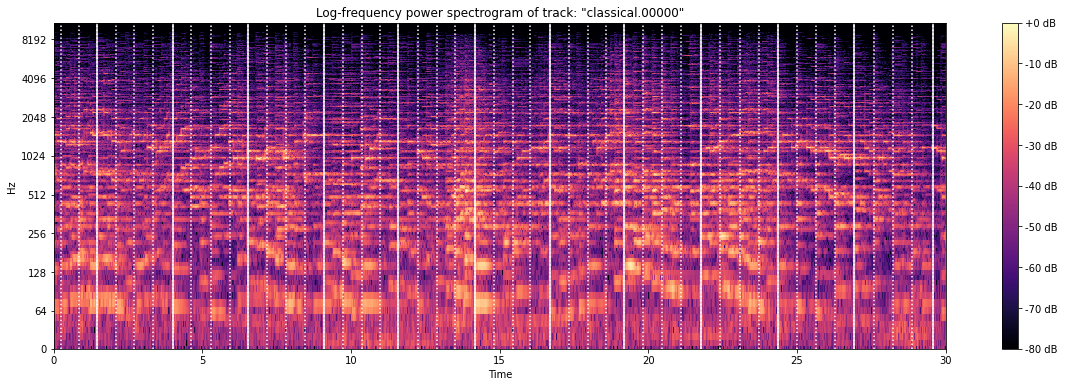

In [31]:
song = train.ids[0]

track = tracks[song]
audio, sr = track.audio
hop_length = 512

spec = librosa.amplitude_to_db(np.abs(librosa.stft(audio, hop_length=hop_length)), ref=np.max)
img = librosa.display.specshow(spec, y_axis='log', sr=sr, hop_length=hop_length, x_axis='time')
plt.vlines(track.beats.times, 0, sr / 2, linestyles='dotted', color='w')
plt.vlines(track.beats.times[track.beats.positions == 1], 0, sr / 2, color='w')
plt.title(f'Log-frequency power spectrogram of track: "{song}"')
plt.colorbar(format="%+2.f dB")
plt.show()

## Put everything together

Finally create the network, add an optimizer, loss functions and metrics to it, and compile the graph.

In [32]:
# use a training sample to infer input shape
input_shape = (None,) + train[0][0].shape[-2:]
model = create_model(input_shape)

learnrate = 0.005
clipnorm = 0.5

optimizer = Lookahead(RAdam(lr=learnrate, clipnorm=clipnorm))
model.compile(
    optimizer=optimizer,
    loss=[
        build_masked_loss(K.binary_crossentropy),
        build_masked_loss(K.binary_crossentropy),
        build_masked_loss(K.binary_crossentropy),
    ],
    metrics=['binary_accuracy'],
)
model.summary(200)

Model: "model_2"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
input_2 (InputLayer)                                              (None, None, 81, 1)                         0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
conv_1_conv (Conv2D)                                              (None, None, 79, 20)                        200                     input_2[0][0]                                

## Train network

We train the network for 100 epochs, each epoch randomly iterating over all sequences (i.e. songs) of the dataset.

Whenever a better performance is observed (i.e. lower loss), we store the model.

If the performance does not increase for a certain number of epochs, we reduce the learnrate by a factor of 5.
If no further improvement can be observed, we stop the training (early stopping).

We log everything to a Tensorboard log.

In [33]:
setting = 'multitask_small_gtzan_small'
epochs = 100
verbose = 0

# create output dir
outdir = f'{PATH}/ismir_2021_tutorial/{setting}'
os.makedirs(outdir, exist_ok=True)
print(f'output dir: {outdir}')

# model checkpointing
mc = keras.callbacks.ModelCheckpoint(f'{outdir}/model_best.h5', monitor='loss', save_best_only=True, verbose=verbose)

# learn rate scheduler
lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.2, patience=10, verbose=1, mode='auto', min_delta=1e-3, cooldown=0, min_lr=1e-7
)

# early stopping
es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4, patience=20, verbose=verbose)

# tensorboard logging
tb = keras.callbacks.TensorBoard(log_dir=f'{outdir}/logs', write_graph=True, write_images=True)

# actually train network
history = model.fit_generator(
    train,
    steps_per_epoch=len(train),
    epochs=epochs,
    shuffle=True,
    validation_data=test,
    validation_steps=len(test),
    callbacks=[mc, es, tb, lr],
)
model.save(f'{outdir}/model_final.h5')

output dir: /content/drive/My Drive/ismir_2021_tutorial/multitask_small_gtzan_small
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
80/80 [==============================] - 14s 171ms/step - loss: 2.1164 - beats_loss: 1.7282 - downbeats_loss: 0.3121 - tempo_loss: 0.0761 - beats_binary_accuracy: 0.7761 - downbeats_binary_accuracy: 0.9392 - tempo_binary_accuracy: 0.9830 - val_loss: 0.2793 - val_beats_loss: 0.1520 - val_downbeats_loss: 0.0524 - val_tempo_loss: 0.0509 - val_beats_binary_accuracy: 0.9482 - val_downbeats_binary_accuracy: 0.9869 - val_tempo_binary_accuracy: 0.9833



Epoch 2/100
80/80 [==============================] - 4s 50ms/step - loss: 0.3027 - beats_loss: 0.1809 - downbeats_loss: 0.0733 - tempo_loss: 0.0485 - beats_binary_accuracy: 0.9390 - downbeats_binary_accuracy: 0.9838 - tempo_binary_accuracy: 0.9833 - val_loss: 0.2395 - val_beats_loss: 0.1289 - val_downbeats_loss: 0.0464 - val_tempo_loss: 0.0480 - val_beats_binary_accuracy: 0.9483 - val_downbeats_binary_accuracy: 0.9869 - val_tempo_binary_accuracy: 0.9833
Epoch 3/100
80/80 [==============================] - 4s 50ms/step - loss: 0.2556 - beats_loss: 0.1489 - downbeats_loss: 0.0610 - tempo_loss: 0.0458 - beats_binary_accuracy: 0.9391 - downbeats_binary_accuracy: 0.9844 - tempo_binary_accuracy: 0.9833 - val_loss: 0.2257 - val_beats_loss: 0.1247 - val_downbeats_loss: 0.0454 - val_tempo_loss: 0.0465 - val_beats_binary_accuracy: 0.9482 - val_downbeats_binary_accuracy: 0.9869 - val_tempo_binary_accuracy: 0.9833
Epoch 4/100
80/80 [==============================] - 4s 49ms/step - loss: 0.2401 - b

# Post-processing

After training has finished, the model is able to predict beats, downbeats, and tempo.

The performance can be greatly improved by post-processing the raw outputs of the network.

For beats and downbeats a dynamic Bayesian network apprach is chosen.
Tempo output is only smoothed and interpolated to determine the final tempo in BPM.

In [34]:
# track beats with a DBN
beat_tracker = madmom.features.beats.DBNBeatTrackingProcessor(
    min_bpm=55.0, max_bpm=215.0, fps=FPS, transition_lambda=100, threshold=0.05
)

# track downbeats with a DBN
# as input, use a combined beat & downbeat activation function
downbeat_tracker = madmom.features.downbeats.DBNDownBeatTrackingProcessor(
    beats_per_bar=[3, 4], min_bpm=55.0, max_bpm=215.0, fps=FPS, transition_lambda=100
)

# track bars, i.e. first track the beats and then infer the downbeat positions
bar_tracker = madmom.features.downbeats.DBNBarTrackingProcessor(
    beats_per_bar=(3, 4), meter_change_prob=1e-3, observation_weight=4
)

In [35]:
def detect_tempo(bins, hist_smooth=11, min_bpm=10):
    min_bpm = int(np.floor(min_bpm))
    tempi = np.arange(min_bpm, len(bins))
    bins = bins[min_bpm:]
    # smooth histogram bins
    if hist_smooth > 0:
        bins = madmom.audio.signal.smooth(bins, hist_smooth)
    # create interpolation function
    interpolation_fn = interp1d(tempi, bins, 'quadratic')
    # generate new intervals with 1000x the resolution
    tempi = np.arange(tempi[0], tempi[-1], 0.001)
    # apply quadratic interpolation
    bins = interpolation_fn(tempi)
    peaks = argrelmax(bins, mode='wrap')[0]
    if len(peaks) == 0:
        # no peaks, no tempo
        tempi = np.array([], ndmin=2)
    elif len(peaks) == 1:
        # report only the strongest tempo
        ret = np.array([tempi[peaks[0]], 1.0])
        tempi = np.array([tempi[peaks[0]], 1.0])
    else:
        # sort the peaks in descending order of bin heights
        sorted_peaks = peaks[np.argsort(bins[peaks])[::-1]]
        # normalize their strengths
        strengths = bins[sorted_peaks]
        strengths /= np.sum(strengths)
        # return the tempi and their normalized strengths
        ret = np.array(list(zip(tempi[sorted_peaks], strengths)))
        tempi = np.array(list(zip(tempi[sorted_peaks], strengths)))
    return tempi[:2]

In [36]:
# function to predict the model's output(s), post-process everything and save if needed
def predict(model, dataset, detdir=None, activations={}, detections={}):

    for i, t in enumerate(dataset):
        # file name
        f = dataset.ids[i]
        # print progress
        sys.stderr.write('\rprocessing file %d of %d: %12s' % (i + 1, len(dataset), f))
        sys.stderr.flush()
        # predict activations
        x = t[0]
        beats, downbeats, tempo = model.predict(x)
        beats_act = beats.squeeze()
        downbeats_act = downbeats.squeeze()
        tempo_act = tempo.squeeze()
        # beats
        beats = beat_tracker(beats_act)
        # downbeats
        combined_act = np.vstack((np.maximum(beats_act - downbeats_act, 0), downbeats_act)).T
        downbeats = downbeat_tracker(combined_act)
        # bars (i.e. track beats and then downbeats)
        beat_idx = (beats * FPS).astype(np.int)
        bar_act = maximum_filter1d(downbeats_act, size=3)
        bar_act = bar_act[beat_idx]
        bar_act = np.vstack((beats, bar_act)).T
        try:
            bars = bar_tracker(bar_act)
        except IndexError:
            bars = np.empty((0, 2))
        # tempo
        tempo = detect_tempo(tempo_act)

        # collect activations and detections
        activations[f] = {'beats': beats_act, 'downbeats': downbeats_act, 'combined': combined_act, 'tempo': tempo_act}
        detections[f] = {'beats': beats, 'downbeats': downbeats, 'bars': bars, 'tempo': tempo}

        # save activations & detections
        if detdir is not None:
            os.makedirs(detdir, exist_ok=True)
            np.save('%s/%s.beats.npy' % (detdir, f), beats_act)
            np.save('%s/%s.downbeats.npy' % (detdir, f), downbeats_act)
            np.save('%s/%s.tempo.npy' % (detdir, f), tempo_act)
            madmom.io.write_beats(beats, '%s/%s.beats.txt' % (detdir, f))
            madmom.io.write_beats(downbeats, '%s/%s.downbeats.txt' % (detdir, f))
            madmom.io.write_beats(bars, '%s/%s.bars.txt' % (detdir, f))
            madmom.io.write_tempo(tempo, '%s/%s.bpm.txt' % (detdir, f))

    return activations, detections

### Predict on test set

Loading of model is only needed if model is not defined, i.e. it was trained in a previous run of the notebook.

In [37]:
# if training did not finish, but was almost there, use `model_best.h5` instead of `model_final.h5`
# model = keras.models.load_model(f'{outdir}/model_best.h5', compile=False)
# model = keras.models.load_model(f'{outdir}/model_final.h5', compile=False)

Predict the model's activations (i.e. the raw outputs) and the post-processed detections.

In [38]:
# create a directory to put the activations and detections into
detdir = f'{outdir}/detections/'

# we can use validation set as test set, since we did not use it for anything besides monitoring progress
activations, detections = predict(model, test, detdir)

processing file 20 of 20:  metal.00008

# Evaluation


In [39]:
def evaluate_beats(detections, annotations):
    evals = []
    for key, det in detections.items():
        ann = annotations[key]
        e = madmom.evaluation.beats.BeatEvaluation(det, ann)
        evals.append(e)
    return madmom.evaluation.beats.BeatMeanEvaluation(evals)


def evaluate_downbeats(detections, annotations):
    evals = []
    for key, det in detections.items():
        ann = annotations[key]
        e = madmom.evaluation.beats.BeatEvaluation(det, ann, downbeats=True)
        evals.append(e)
    return madmom.evaluation.beats.BeatMeanEvaluation(evals)


def evaluate_tempo(detections, annotations):
    evals = []
    for key, det in detections.items():
        ann = annotations[key]
        e = madmom.evaluation.tempo.TempoEvaluation(det, ann)
        evals.append(e)
    return madmom.evaluation.tempo.TempoMeanEvaluation(evals)

## Evaluate beats & tempo

In [40]:
beat_detections = {k: v['beats'] for k, v in detections.items()}
downbeat_detections = {k: v['downbeats'] for k, v in detections.items()}
bar_detections = {k: v['bars'] for k, v in detections.items()}
tempo_detections = {k: v['tempo'][0, 0] for k, v in detections.items()}

beat_annotations = {k: v.beats.times for k, v in tracks.items() if v.beats is not None}
downbeat_annotations = {k: v.beats.times[v.beats.positions == 1] for k, v in tracks.items() if v.beats is not None}
tempo_annotations = {k: v.tempo for k, v in tracks.items() if v.tempo is not None}

# evaluate beats
print('Beat evaluation\n---------------')
print(' Beat tracker:    ', evaluate_beats(beat_detections, beat_annotations))
print(' Downbeat tracker:', evaluate_beats(downbeat_detections, beat_annotations))

# evaluate downbeats
print('\nDownbeat evaluation\n-------------------')
print(' Bar tracker:     ', evaluate_downbeats(bar_detections, downbeat_annotations))
print(' Downbeat tracker:', evaluate_downbeats(downbeat_detections, downbeat_annotations))

# evaluate tempo
print('\nTempo evaluation\n----------------')
print(' Tempo:           ', evaluate_tempo(tempo_detections, tempo_annotations))

Beat evaluation
---------------
 Beat tracker:     mean for 20 files
  F-measure: 0.770 P-score: 0.747 Cemgil: 0.694 Goto: 0.650 CMLc: 0.536 CMLt: 0.582 AMLc: 0.806 AMLt: 0.864 D: 2.838 Dg: 1.620
 Downbeat tracker: mean for 20 files
  F-measure: 0.771 P-score: 0.743 Cemgil: 0.694 Goto: 0.650 CMLc: 0.533 CMLt: 0.578 AMLc: 0.804 AMLt: 0.860 D: 2.822 Dg: 1.623

Downbeat evaluation
-------------------
 Bar tracker:      mean for 20 files
  F-measure: 0.368 P-score: 0.414 Cemgil: 0.319 Goto: 0.350 CMLc: 0.299 CMLt: 0.299 AMLc: 0.623 AMLt: 0.623 D: 4.006 Dg: 1.783
 Downbeat tracker: mean for 20 files
  F-measure: 0.409 P-score: 0.498 Cemgil: 0.362 Goto: 0.400 CMLc: 0.370 CMLt: 0.370 AMLc: 0.626 AMLt: 0.626 D: 4.021 Dg: 1.856

Tempo evaluation
----------------
 Tempo:            mean for 20 files
  pscore=0.550 (one tempo: 0.550, all tempi: 0.550) acc1=0.550 acc2=0.850


For reference, a model trained on the full GTZAN dataset has the following performance:
```
Beat evaluation
---------------
 Beats:     mean for 20 files
  F-measure: 0.767 P-score: 0.740 Cemgil: 0.696 Goto: 0.650 CMLc: 0.536 CMLt: 0.580 AMLc: 0.748 AMLt: 0.811 D: 2.817 Dg: 1.686
 Downbeats: mean for 20 files
  F-measure: 0.789 P-score: 0.765 Cemgil: 0.714 Goto: 0.700 CMLc: 0.597 CMLt: 0.636 AMLc: 0.761 AMLt: 0.816 D: 2.887 Dg: 1.723

Downbeat evaluation
-------------------
 Bars:      mean for 20 files
  F-measure: 0.483 P-score: 0.536 Cemgil: 0.443 Goto: 0.550 CMLc: 0.406 CMLt: 0.415 AMLc: 0.756 AMLt: 0.764 D: 3.963 Dg: 2.039
 Downbeats: mean for 20 files
  F-measure: 0.566 P-score: 0.619 Cemgil: 0.522 Goto: 0.650 CMLc: 0.529 CMLt: 0.529 AMLc: 0.788 AMLt: 0.788 D: 4.013 Dg: 2.085

Tempo evaluation
----------------
 Tempo:      mean for 20 files
  pscore=0.650 (one tempo: 0.650, all tempi: 0.650) acc1=0.650 acc2=0.900
```

## Visualisation

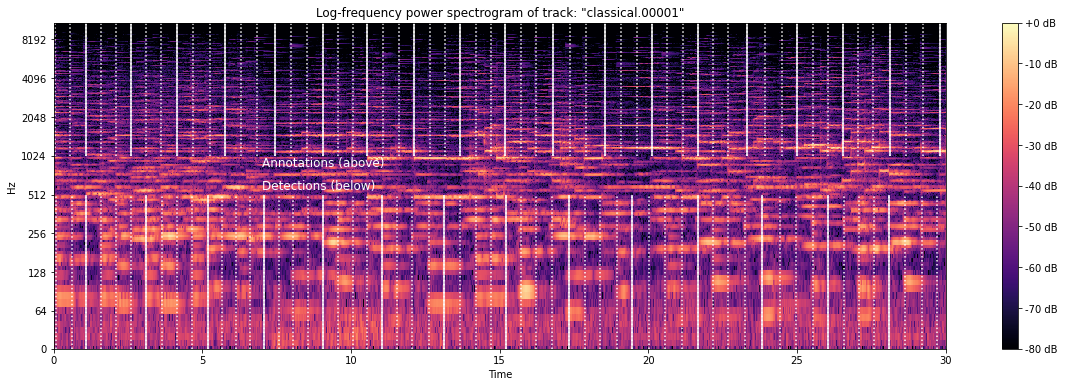

In [41]:
song = test.ids[0]

det = detections[song]

track = tracks[song]
audio, sr = track.audio
hop_length = 512

spec = librosa.amplitude_to_db(np.abs(librosa.stft(audio, hop_length=hop_length)), ref=np.max)
librosa.display.specshow(spec, y_axis='log', sr=sr, hop_length=hop_length, x_axis='time')
plt.title(f'Log-frequency power spectrogram of track: "{song}"')
plt.colorbar(format="%+2.f dB")
# plot annotations in the upper part
plt.vlines(track.beats.times, hop_length * 2, sr / 2, linestyles='dotted', color='w')
plt.vlines(track.beats.times[track.beats.positions == 1], hop_length * 2, sr / 2, color='w')
plt.text(7, hop_length * 1.65, 'Annotations (above)', color='w', fontsize=12)
# plot detections in the lower part
plt.vlines(det['downbeats'][:, 0], 0, hop_length, linestyles='dotted', color='w')
plt.vlines(det['downbeats'][det['downbeats'][:, 1] == 1][:, 0], 0, hop_length, color='w')
plt.text(7, hop_length * 1.1, 'Detections (below)', color='w', fontsize=12)
plt.show()

# Data augmentation

Using only very few songs often results in poor generalisation.
To increase the amount of training data without requiring more annotated data, data augmentation can be used.

We use a simple approach of adding the same training examples with changed hop-size when computing the STFT.
This results in the same song being represented with a different numbers of frames.
This way the beat positions are "streched" or "squeezed" and the tempo changes accordingly.

In [42]:
for fps in [95, 97.5, 102.5, 105]:
    ds = DataSequence(
        tracks={f'{k}_{fps}': v for k, v in tracks.items() if k in train_files},
        pre_processor=PreProcessor(fps=fps),
        pad_frames=pad_frames,
    )
    ds.widen_beat_targets()
    ds.widen_downbeat_targets()
    ds.widen_tempo_targets(3, 0.5)
    ds.widen_tempo_targets(3, 0.5)
    train.append(ds)

print(len(train))

processing track 80/80: metal.00009_105                    

400


## Re-train network

In [43]:
epochs = 50
verbose = 0
num_features = 20

setting = 'multitask_small_gtzan_mini_augmented'

# create output dir
outdir = f'{PATH}/ismir_2021_tutorial/{setting}'
os.makedirs(outdir, exist_ok=True)
print(f'output dir: {outdir}')

# model checkpointing
mc = keras.callbacks.ModelCheckpoint(f'{outdir}/model_best.h5', monitor='loss', save_best_only=True, verbose=verbose)

# early stopping
es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4, patience=20, verbose=verbose)

# tensorboard logging
tb = keras.callbacks.TensorBoard(log_dir=f'{outdir}/logs', write_graph=True, write_images=True)

# learn rate scheduler
lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.2, patience=10, verbose=1, mode='auto', min_delta=1e-3, cooldown=0, min_lr=1e-7
)

# train network
history = model.fit_generator(
    train,
    steps_per_epoch=len(train),
    epochs=epochs,
    shuffle=True,
    validation_data=test,
    validation_steps=len(test),
    callbacks=[mc, es, tb, lr],
)
model.save(f'{outdir}/model_final.h5')

output dir: /content/drive/My Drive/ismir_2021_tutorial/multitask_small_gtzan_mini_augmented
Epoch 1/50
400/400 [==============================] - 27s 68ms/step - loss: 0.1573 - beats_loss: 0.0918 - downbeats_loss: 0.0379 - tempo_loss: 0.0276 - beats_binary_accuracy: 0.9433 - downbeats_binary_accuracy: 0.9850 - tempo_binary_accuracy: 0.9834 - val_loss: 0.1275 - val_beats_loss: 0.1118 - val_downbeats_loss: 0.0418 - val_tempo_loss: 0.0374 - val_beats_binary_accuracy: 0.9493 - val_downbeats_binary_accuracy: 0.9869 - val_tempo_binary_accuracy: 0.9837
Epoch 2/50
400/400 [==============================] - 20s 49ms/step - loss: 0.1458 - beats_loss: 0.0868 - downbeats_loss: 0.0368 - tempo_loss: 0.0223 - beats_binary_accuracy: 0.9439 - downbeats_binary_accuracy: 0.9850 - tempo_binary_accuracy: 0.9835 - val_loss: 0.1269 - val_beats_loss: 0.1120 - val_downbeats_loss: 0.0416 - val_tempo_loss: 0.0335 - val_beats_binary_accuracy: 0.9504 - val_downbeats_binary_accuracy: 0.9869 - val_tempo_binary_accu

## Re-predict on test set

In [44]:
# create a directory to put the activations and detections into
detdir = f'{outdir}/detections/'

# make predictions for the held-out test set
activations, detections = predict(model, test, detdir)

processing file 20 of 20:  metal.00008

## Re-evaluate beats & tempo

When comparing the model's performance trained with data augmentation to the original model, one should keep in mind that depending on the nature of the dataset (i.e. style of songs, tempo distribution, etc.) data augmentation might not lead to increased performance at all, especially if only very training examples are used.

In [45]:
beat_detections = {k: v['beats'] for k, v in detections.items()}
downbeat_detections = {k: v['downbeats'] for k, v in detections.items()}
bar_detections = {k: v['bars'] for k, v in detections.items()}
tempo_detections = {k: v['tempo'][0, 0] for k, v in detections.items()}

beat_annotations = {k: v.beats.times for k, v in tracks.items() if v.beats is not None}
downbeat_annotations = {k: v.beats.times[v.beats.positions == 1] for k, v in tracks.items() if v.beats is not None}
tempo_annotations = {k: v.tempo for k, v in tracks.items() if v.tempo is not None}

# evaluate beats
print('Beat evaluation\n---------------')
print(' Beat tracker:    ', evaluate_beats(beat_detections, beat_annotations))
print(' Downbeat tracker:', evaluate_beats(downbeat_detections, beat_annotations))

# evaluate downbeats
print('\nDownbeat evaluation\n-------------------')
print(' Bar tracker:     ', evaluate_downbeats(bar_detections, downbeat_annotations))
print(' Downbeat tracker:', evaluate_downbeats(downbeat_detections, downbeat_annotations))

# evaluate tempo
print('\nTempo evaluation\n----------------')
print(' Tempo:           ', evaluate_tempo(tempo_detections, tempo_annotations))

Beat evaluation
---------------
 Beat tracker:     mean for 20 files
  F-measure: 0.787 P-score: 0.757 Cemgil: 0.716 Goto: 0.650 CMLc: 0.585 CMLt: 0.617 AMLc: 0.778 AMLt: 0.856 D: 2.939 Dg: 1.725
 Downbeat tracker: mean for 20 files
  F-measure: 0.797 P-score: 0.764 Cemgil: 0.727 Goto: 0.700 CMLc: 0.593 CMLt: 0.624 AMLc: 0.780 AMLt: 0.858 D: 2.974 Dg: 1.772

Downbeat evaluation
-------------------
 Bar tracker:      mean for 20 files
  F-measure: 0.410 P-score: 0.412 Cemgil: 0.374 Goto: 0.400 CMLc: 0.305 CMLt: 0.305 AMLc: 0.784 AMLt: 0.784 D: 4.111 Dg: 2.352
 Downbeat tracker: mean for 20 files
  F-measure: 0.362 P-score: 0.427 Cemgil: 0.333 Goto: 0.400 CMLc: 0.314 CMLt: 0.314 AMLc: 0.667 AMLt: 0.667 D: 4.193 Dg: 2.009

Tempo evaluation
----------------
 Tempo:            mean for 20 files
  pscore=0.750 (one tempo: 0.750, all tempi: 0.750) acc1=0.750 acc2=0.950


Although beats & downbeats performance does not increase much, data augmentation improves tempo accuracy by ~20%.

```
Beat evaluation
---------------
 Beat tracker:     mean for 20 files
  F-measure: 0.770 P-score: 0.747 Cemgil: 0.694 Goto: 0.650 CMLc: 0.536 CMLt: 0.582 AMLc: 0.806 AMLt: 0.864 D: 2.838 Dg: 1.620
 Downbeat tracker: mean for 20 files
  F-measure: 0.771 P-score: 0.743 Cemgil: 0.694 Goto: 0.650 CMLc: 0.533 CMLt: 0.578 AMLc: 0.804 AMLt: 0.860 D: 2.822 Dg: 1.623

Downbeat evaluation
-------------------
 Bar tracker:      mean for 20 files
  F-measure: 0.368 P-score: 0.414 Cemgil: 0.319 Goto: 0.350 CMLc: 0.299 CMLt: 0.299 AMLc: 0.623 AMLt: 0.623 D: 4.006 Dg: 1.783
 Downbeat tracker: mean for 20 files
  F-measure: 0.409 P-score: 0.498 Cemgil: 0.362 Goto: 0.400 CMLc: 0.370 CMLt: 0.370 AMLc: 0.626 AMLt: 0.626 D: 4.021 Dg: 1.856

Tempo evaluation
----------------
 Tempo:            mean for 20 files
  pscore=0.550 (one tempo: 0.550, all tempi: 0.550) acc1=0.550 acc2=0.850
```

The impact of data augmentation can be better observed with a model model trained on the full GTZAN dataset:
```
Beat evaluation
---------------
 Beats:     mean for 20 files
  F-measure: 0.909 P-score: 0.914 Cemgil: 0.845 Goto: 0.950 CMLc: 0.860 CMLt: 0.909 AMLc: 0.883 AMLt: 0.945 D: 3.511 Dg: 2.515
 Downbeats: mean for 20 files
  F-measure: 0.904 P-score: 0.910 Cemgil: 0.841 Goto: 0.950 CMLc: 0.859 CMLt: 0.905 AMLc: 0.883 AMLt: 0.941 D: 3.489 Dg: 2.470

Downbeat evaluation
-------------------
 Bars:      mean for 20 files
  F-measure: 0.681 P-score: 0.755 Cemgil: 0.639 Goto: 0.750 CMLc: 0.742 CMLt: 0.742 AMLc: 0.916 AMLt: 0.916 D: 4.702 Dg: 3.228
 Downbeats: mean for 20 files
  F-measure: 0.661 P-score: 0.743 Cemgil: 0.616 Goto: 0.750 CMLc: 0.729 CMLt: 0.729 AMLc: 0.912 AMLt: 0.912 D: 4.613 Dg: 3.031

Tempo evaluation
----------------
 Tempo:      mean for 20 files
  pscore=0.950 (one tempo: 0.950, all tempi: 0.950) acc1=0.950 acc2=0.950
```

For comparison the same model trained on the full GTZAN dataset without augmentation: 

```
Beat evaluation
---------------
 Beats:     mean for 20 files
  F-measure: 0.767 P-score: 0.740 Cemgil: 0.696 Goto: 0.650 CMLc: 0.536 CMLt: 0.580 AMLc: 0.748 AMLt: 0.811 D: 2.817 Dg: 1.686
 Downbeats: mean for 20 files
  F-measure: 0.789 P-score: 0.765 Cemgil: 0.714 Goto: 0.700 CMLc: 0.597 CMLt: 0.636 AMLc: 0.761 AMLt: 0.816 D: 2.887 Dg: 1.723

Downbeat evaluation
-------------------
 Bars:      mean for 20 files
  F-measure: 0.483 P-score: 0.536 Cemgil: 0.443 Goto: 0.550 CMLc: 0.406 CMLt: 0.415 AMLc: 0.756 AMLt: 0.764 D: 3.963 Dg: 2.039
 Downbeats: mean for 20 files
  F-measure: 0.566 P-score: 0.619 Cemgil: 0.522 Goto: 0.650 CMLc: 0.529 CMLt: 0.529 AMLc: 0.788 AMLt: 0.788 D: 4.013 Dg: 2.085

Tempo evaluation
----------------
 Tempo:      mean for 20 files
  pscore=0.650 (one tempo: 0.650, all tempi: 0.650) acc1=0.650 acc2=0.900
```


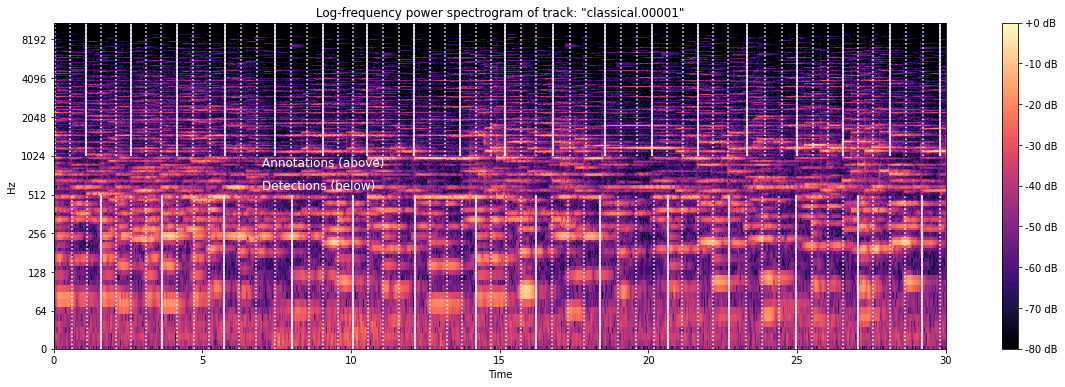

In [46]:
song = test.ids[0]

det = detections[song]

track = tracks[song]
audio, sr = track.audio
hop_length = 512

spec = librosa.amplitude_to_db(np.abs(librosa.stft(audio, hop_length=hop_length)), ref=np.max)
librosa.display.specshow(spec, y_axis='log', sr=sr, hop_length=hop_length, x_axis='time')
plt.title(f'Log-frequency power spectrogram of track: "{song}"')
plt.colorbar(format="%+2.f dB")
# plot annotations in the upper part
plt.vlines(track.beats.times, hop_length * 2, sr / 2, linestyles='dotted', color='w')
plt.vlines(track.beats.times[track.beats.positions == 1], hop_length * 2, sr / 2, color='w')
plt.text(7, hop_length * 1.65, 'Annotations (above)', color='w', fontsize=12)
# plot detections in the lower part
plt.vlines(det['downbeats'][:, 0], 0, hop_length, linestyles='dotted', color='w')
plt.vlines(det['downbeats'][det['downbeats'][:, 1] == 1][:, 0], 0, hop_length, color='w')
plt.text(7, hop_length * 1.1, 'Detections (below)', color='w', fontsize=12)
plt.show()